In [ ]:
# Topic Modeling for Harry Potter - the benefits of a background corpus

In this notebook, we will focus on a case study of Topic Modeling in relation to the Harry Potter book series. Our ultimate goal is to find an answer to the question which subjects have become more prominent in the book series, and which ones have faded more into the background.

In [ ]:
# Let's start with importing some basic packages that we will use throughout this notebook.
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
from collections import Counter

## The Books Corpus

Most approaches to Topic Modeling build on **unsupervised algorithms**. They rely on large corpora of texts for which *no metadata whatsoever* is available. As such, these algorithms do not require any additional human input (hence: "unsupervised") and they only have access to the actual, "raw" texts themselves. This aspect is valuable from a Humanities perspective, since it has the potential to generate results that are **less biased towards pre-existing hypotheses** about the data.

The **downside** of unsupervised algorithms is that they are generally extremely **data hungry** and require relatively large -- according the Humanities standards, even huge -- datasets to yield useful models. A good **Topic Model** typically needs to be fed tens of thousands of documents to infer useful topical representations. Applying such models to smaller datasets is often difficult, especially because it makes the standard approaches much more brittle in terms of the initial parameter settings for algorithms (which can be hard to tune). The Harry Potter collection, for instance, is too small and topically biased towards the Hogwarts "storyverse" to yield a trustworthy analysis.

Because of this reason, we will work with an interesting **background corpus** on which we can train our semantic models before applying them to Harry Potter. We will work with the so-called **Books Corpus** ([Zhu et al., 'Aligning Books and Movies: Towards Story-like Visual Explanations by Watching Movies and Reading Books', *arXiv* (2015)](https://arxiv.org/pdf/1506.06724.pdf)). The corpus can be obtained for non-commercial research purposes via [this website](http://yknzhu.wixsite.com/mbweb).

![Zhu et al. (2015)](img/Zhu_et_al_1.png)
![Zhu et al. (2015)](img/Zhu_et_al_2.png "From: Zhu et al. 2015")

This corpus has upsides and downsides:

* Its main advantage is that it offers a **large collection of contemporary, self-published, English-language, novel-length fiction** that is available for research purposes (+11K novels, although it contains a good share of duplicates which, for some reason, have not been removed). Most of the latest studies in digital text analysis are nowadays geared on historic material that is free of copyright; this creates a uneasy lacuna of scholarly work that targets contemporary literature, such as Harry Potter. Because of its contemporary nature, the Books Corpus therefore serves as a rare point of reference for the analysis of contemporary fiction.

* Secondly, the Books Corpus has **genre labels**, which have been assigned by the authors themselves, when uploading their work to the popular [Smashwords](https://www.smashwords.com/) platform, from which this data was harvested. These genre indications can be considered an intricate form of present-day "reader response", namely that by authors to their *own* work. We will be able to leverage these labels in interesting ways below.

* The downside of this corpus is that is **not exceptionally well curated** (cf. the many duplicates it contains), and apart from the genre labels, we do not have access to any other **metadata** about the texts (e.g. date of publication) or their authors (e.g. the author's native language).

* Additionally, most of this fiction is **self-published** and some of these books therefore be expected to be of a quite different nature and orientation than the fiction which has been heavily edited and mediated by traditional gatekeepers, such as established publishers.

* Finally, the genre labels should be taken with a grain of salt: since these were self-assigned by the authors, we have to account for the possibility that these authors actually aimed to promote their own work through embellishing it with high-status labels, such as the "Literature" tag (see below). Theoretically, these genre labels therefore tie in closely with mechanisms of **self-fashioning**.

## Preprocess the data

Since we are interested in topical content for our case study, we want to work with models that are strongly geared towards the semantics (rather than the stylistics). In such semantic analyses, it is quite common to throw out function words (without a clear referential meaning, sometimes called **stop words**) already at the preprocessing stage, and only retain the **content words**.

Because the Books corpus is very large, we have **tagged** the entire Books Corpus (using the [Spacy](https://spacy.io/) package, v. 2.0/4) and created a version of the data set in which:

- all duplicate books have been removed
- only adjectives (`ADJ`), nouns (`NOUN`), verbs (`VERB`) have been retained
- the genre information about the books has been collected into a more convenient json-formatted metadata file (`books_meta.json`)

The preprocessing code is included in the rest of this section for reference purposes, but you can safely ignore this, if you are only interested in running the semantic analyses.

```python
import os
import json
import glob
import shutil

# limit to only three tags in Universal Part-of-Speech tagset
allowed = set('ADJ NOUN VERB'.split())
```

```python
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

def preprocess(filenames, max_nb=None):
    try:
        shutil.rmtree('books')
    except FileNotFoundError:
        pass
    os.mkdir('books')
    
    books = {}
    for filename in filenames:
        comps = filename.split('/')
        genre, title = comps[-2:]
        
        if title in books:
            books[title].append(genre)
            continue
        else:
            books[title] = [genre]
        
        with open(filename, 'r') as f:
            try:
                text = f.read()
            except UnicodeDecodeError:
                continue
            tokens = nlp(text)
            if tokens:
                with open('books/' + title, 'w') as newf:
                    for t in tokens:
                        if t.pos_ in allowed and t.is_alpha and not t.is_stop:
                            newf.write(t.text.lower() + ' ')
        if max_nb and len(books) > max_nb:
            break
    
    with open('books_meta.json', 'w') as f:
        f.write(json.dumps(books, indent=4))
```

```python
import glob
path = 'books_txt_full/*/*.txt' # path to the original book files
filenames = sorted(list(glob.glob(path)))
preprocess(filenames)
```

## Setting up our code base

The Books Corpus mostly contains novel-length texts. Most of the popular models in distributional semantics, however, have been developed to work with much *shorter text fragments*, such as the abstracts of scientific papers (somewhere in the range of 250-500 words, one could say). Because of this, we define a "chunk yielder" below: this is tool that we can use to iterate of the corpus and which in each iteration will return a **fixed-length chunk**, i.e. slice of consecutive words from a particular novel (after removing all content words).

Using the chunk generator offers the additional advantage that we do not have to load the entire corpus in memory at once, which is useful on more modest computers that do not have lots of RAM memory.

In [ ]:
import glob
import random
RND = 12345
random.seed(RND)

class Chunker(object):
    def __init__(self, filenames, metadata, singles_only=False,
                 max_chars_per_book=None, chunk_size=None):

        # maximum number of characters to read from the beginning of each book:
        self.max_chars_per_book = max_chars_per_book

        # size of the chunks returned (in tokens):
        self.chunk_size = chunk_size

        # only return chunks from these files:
        self.filenames = filenames

        # include a dictionary with metadata:
        self.meta = meta

        # only return texts with a single genre label:
        self.singles_only = singles_only

        # only collect genres during the first iteration
        self.first = True

    def __iter__(self):
        if self.first:
            self.genres = []

        for filename in self.filenames:
            title = os.path.basename(filename)
            current_genres = self.meta[title]

            if self.singles_only:
                if len(current_genres) > 1:
                    continue

            with open(filename, 'r', encoding='utf-8') as f:
                try:
                    if self.max_chars_per_book:
                        text = f.read()
                        text = text[:self.max_chars_per_book]
                    else:
                        text = f.read()
                except:
                    continue

            tokens = text.split()

            for i in range(0, len(tokens), self.chunk_size):
                if self.first:
                    self.genres.append(current_genres)
                yield tokens[i:i + self.chunk_size]

        # stop collecting labels after first complete iteration
        self.first = False

Additionally, we set a number of notebook-wide parameters that we will use throughout. Not all of these will make sense yet at this point, but some already will. The size of chunks (`chunk_size`), for instance, is fixed to `1822` to approximate the word length length of a Harry Potter chapter (after the removal of function words etc.).

In [ ]:
n_features = 5000 # number of most common words
n_topics = 30 # number of topics
n_top_words = 60 # number of characteristic words per topic (viz purposes only)
max_df = 0.5 # maximum document frequency
min_df = 100 # minimum document frequency
max_books = 1000 # include all books (None), or a specific number
chunk_size = 1822 # size of average Harry Potter chapter (after keeping only ADJ, NOUN & VERB)

How much individual books do we in fact end up with, after the removal of the duplicate books?

In [ ]:
# uncomment the following lines if you need to unzip books.zip
from zipfile import ZipFile
zf = ZipFile('books.zip', 'r')
zf.extractall('books')
zf.close()

In [ ]:
path = 'books/books/*.txt'
filenames = sorted(list(glob.glob(path)))
print(len(filenames))

6800


We see that there is quite a serious drop in the number of books available (originally that was more than 11,000!). Which metadata do we have available in the json-file?

In [ ]:
import json
with open('books_meta.json', 'r') as f:
    meta = json.loads(f.read())

for book, genres in list(meta.items())[:20]:
    print(f"{book} -> {' - '.join(sorted(genres))}")

100290.txt -> Adventure
108104.txt -> Adventure
112365.txt -> Adventure
113909.txt -> Adventure - Thriller
115062.txt -> Adventure
115933.txt -> Adventure
116700.txt -> Adventure
117250.txt -> Adventure
119290.txt -> Adventure
120163.txt -> Adventure
122450.txt -> Adventure
126259.txt -> Adventure
127912.txt -> Adventure
127958.txt -> Adventure
129009.txt -> Adventure
130411.txt -> Adventure
130847.txt -> Adventure
13577.txt -> Adventure
136764.txt -> Adventure - Thriller
137808.txt -> Adventure


As you will see, for each text file, our metadata contains a list of the self-assigned genre labels. Interestingly, often more than one genre label has been assigned. We randomly shuffle the list of filenames now, to avoid artefacts related to the order of the text files.

In [ ]:
random.seed(RND)
random.shuffle(filenames)
print(filenames[:10])
print(len(filenames))

['books/books/We_Can_Build_You.txt', 'books/books/PrinceCaspian.txt', 'books/books/Big_Girls_Do_06.txt', 'books/books/392303.txt', 'books/books/421926.txt', 'books/books/229689.txt', 'books/books/439376.txt', 'books/books/u3720.txt', 'books/books/u3906.txt', 'books/books/u4145.txt']
6800


During development, we can also limit the number of books to include (for speed purposes):

In [ ]:
if max_books:
    filenames = filenames[:max_books]
print(len(filenames))

1000


Finally, let us calculate the average length of a book in the corpus (after preprocessing):

In [ ]:
lens = []
for fn in filenames:
    with open(fn, 'r') as f:
        lens.append(len(f.read().split()))
import numpy as np
m = np.mean([l for l in lens])
print('Average length of a book in the corpus (after preprocessing): ', m)

Average length of a book in the corpus (after preprocessing):  24414.305


## Inspect the data

After having set up our code base, we are now ready to explore some basic statistics about the data. We first define a generic `chunker`, to which we pass our (potentially truncated) filenames and the metadata:

In [ ]:
chunker = Chunker(filenames, metadata=meta)
print(len(chunker.meta.values()))

7187


How frequent are the individual genre labels in the corpus? We can easily plot these counts in a so-called **bar plot**:

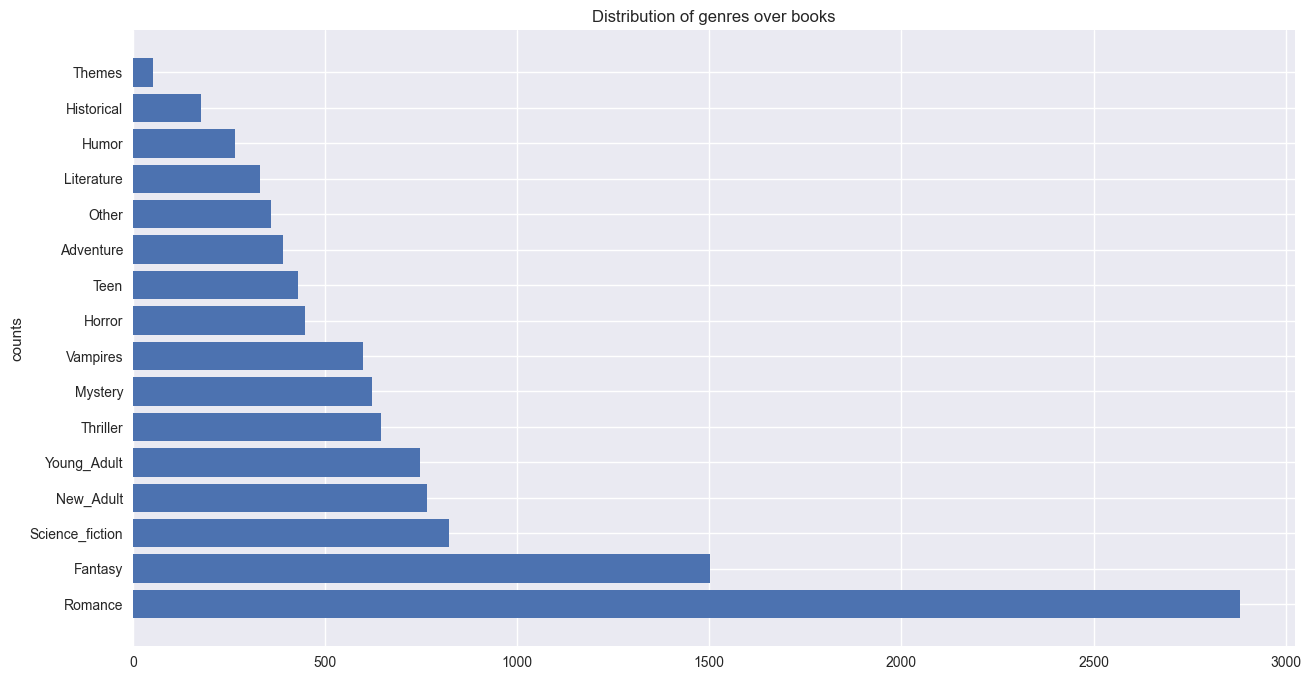

In [ ]:
from operator import itemgetter
plt.figure(figsize=(15, 8))
G = Counter([label for labels in chunker.meta.values() for label in labels])
labels, heights = list(zip(*sorted(list(G.items()), key=itemgetter(1), reverse=True)))
plt.barh(y=range(len(heights)), width=heights)
plt.yticks(range(len(labels)), labels)
plt.ylabel('counts')
plt.title('Distribution of genres over books');

In [ ]:
# What information are we after in this code block?

from collections import Counter
mults = Counter([len(genres) for title, genres in chunker.meta.items()])
print(mults)

Counter({1: 4257, 2: 2101, 3: 741, 4: 82, 5: 6})


## Topic modeling

We are now ready to build a topic model of the Books Corpus.

First, we redefine our `Chunker`. Depending on the time you have at hand, as well as the computing power of the machine on which you run this, you can lower the `max_chars_per_book` parameter to artificially limit the number of characters we load from the beginning of each book.

In [ ]:
chunks = Chunker(filenames, meta,
                 chunk_size=chunk_size,
                 max_chars_per_book=None)

We will base our **topic model** on a **bag-of-words model**. Essentially, this is a large tabular object, in which **rows** represent documents and **columns** represent words in our **vocabulary**. The individual **cells** in the table are populated with simple absolute counts, expressing how often each word occurs in each document (or "novel chunks" in our case).

The construction of a bag-of-words model is taken care of by the `CountVectorizer` below, where we can also specify a number of useful options, such as the minimum frequency (`min_df`) a word should have before it is included in the vocabulary, which is useful to ban unfrequent words, such as **hapaxes**. On the other hand, we can also remove items that occur extremely frequently in the corpus by setting a maximum document frequency (`max_df`) threshold.

In [ ]:
import os
from sklearn.feature_extraction.text import CountVectorizer

def identity(x):
    return x

vectorizer = CountVectorizer(max_df=max_df, min_df=min_df,
                             max_features=n_features,
                             analyzer=identity)
X = vectorizer.fit_transform(chunks)

print(vectorizer.get_feature_names_out()[:200])
print('shape corpus:', X.shape)

['a' 'abandon' 'abandoned' 'abdomen' 'abilities' 'ability' 'abrupt'
 'absence' 'absolute' 'absorbed' 'abuse' 'accent' 'accept' 'acceptance'
 'accepted' 'accepting' 'access' 'accident' 'accompanied' 'accomplish'
 'accomplished' 'according' 'account' 'accounts' 'accurate' 'accused'
 'accustomed' 'ache' 'ached' 'achieve' 'aching' 'acknowledge'
 'acknowledged' 'act' 'acted' 'acting' 'action' 'actions' 'active'
 'activities' 'activity' 'acts' 'actual' 'ad' 'add' 'added' 'adding'
 'addition' 'additional' 'address' 'addressed' 'adds' 'adjust' 'adjusted'
 'admire' 'admired' 'admiring' 'admit' 'admitted' 'adopted' 'adorable'
 'adrenaline' 'adult' 'adults' 'advance' 'advanced' 'advantage'
 'adventure' 'advice' 'advised' 'affair' 'affairs' 'affect' 'affected'
 'affection' 'afford' 'afraid' 'afternoon' 'age' 'aged' 'agency' 'agent'
 'agents' 'ages' 'aggressive' 'agitated' 'agony' 'agree' 'agreed'
 'agreement' 'ai' 'aid' 'aim' 'aimed' 'aiming' 'aircraft' 'airport'
 'aisle' 'alarm' 'alarmed' 'alcoho

Let us plot a subset of our corpus, to show what a BOW model actually looks like:

In [ ]:
import pandas as pd
print('shape corpus:', X.shape)

shape corpus: (13908, 5000)


In [ ]:
bow_example = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
bow_example[['ill', 'country', 'chosen', 'adult', 'money', 'baby']].sample(20)

,ill,country,chosen,adult,money,baby
3244,0,0,0,0,1,0
20,0,0,0,0,0,0
3980,0,0,0,0,0,2
4092,0,0,0,0,0,1
7730,0,0,0,0,0,0
6049,0,0,0,0,0,4
7968,0,0,0,0,0,1
12792,0,0,1,0,0,0
5171,0,0,0,0,1,0
4113,0,0,0,0,1,3


In thematic analyses, such as topic modelling, you want to give more attention words that seem to have a more specific meaning. For this reason, we will apply a very common **scaling** or **weighting** procedure to our corpus, namely TF-IDF (*term frequency-inverse document frequency*). This weighting scheme will modify the weight of words in light of the *inverse document frequency* in the entire collection: if a a term occurs in fewer documents, it will receive a higher IDF-score. Converting our original BOW model to a TF-IDF model is easy using `sklearn`'s `TfidfTransformer`:

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
X_ = transformer.fit_transform(X)

So which words have the least/most specific semantics?

In [ ]:
bin_ = X.toarray()
bin_[bin_ > 0] = 1
sums = np.sum(bin_, axis=0)
sorted_idxs = sums.argsort()
names = np.array(vectorizer.get_feature_names_out())
print('Lowest IDF:')
for i in sorted_idxs[:10]:
    print(names[i], sums[i], end=' - ')
print('\nHighest IDF:')
for i in sorted_idxs[-10:]:
    print(names[i], sums[i], end=' - ')

Lowest IDF:
faerie 113 - mage 148 - thy 164 - ty 164 - trent 166 - nanny 191 - la 193 - dwarf 194 - pirates 196 - sophie 197 - 
Highest IDF:
turning 6852 - today 6909 - window 6919 - nice 6941 - course 6945 - raised 6946 - corner 6948 - giving 6949 - couple 6952 - whispered 6954 - 

### Non-Negative Matrix Factorisation (NMF)

We are now ready to build our topic model. We will use an established method, called **Non-Negative Matrix Factorization** (NMF), which is still used frequently in distributional semantics for building document-level representations.

![NMF](img/NMF_2.png)

Below, we specify a number of parameters:

- `n_components`: the number of topics which we would like to extract.
- `random_state`: just a random digit, to make sure that we get the same results each time we run this block
- `verbose`: we have the procedure print some information during the optimization process
- `max_iter`: the number of "epochs" that the algorithm is allowed to go through the entire dataset


In spite of NMF's unsupervised nature, the number of topics (`n_components`) is an important parameters which you will want to play with.

In [ ]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=n_topics,
          random_state=RND,
          verbose=1, max_iter=50).fit(X_)

violation: 1.0
violation: 0.2511075424532288
violation: 0.1452326217374832
violation: 0.10818446745598179
violation: 0.08258827673674994
violation: 0.06500067647407891
violation: 0.05379459432792889
violation: 0.04712486134553902
violation: 0.04329650429081301
violation: 0.03994842026110133
violation: 0.03626801056871273
violation: 0.03233559690321125
violation: 0.028902567549955693
violation: 0.02623506762083443
violation: 0.023854722071705338
violation: 0.021693964606172907
violation: 0.019736331105705596
violation: 0.01812315668288416
violation: 0.016738776094255822
violation: 0.015581692748200877
violation: 0.014593614106049
violation: 0.013760751001495784
violation: 0.013057894123502813
violation: 0.012458281873179038
violation: 0.011913384700981739
violation: 0.01137856298207296
violation: 0.010875746971134
violation: 0.01033921127602565
violation: 0.009790056265641273
violation: 0.009235116849996323
violation: 0.008669041438999757
violation: 0.008091047485530774
violation: 0.007

/opt/anaconda3/envs/cls/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 50 reached. Increase it to improve convergence.
  warnings.warn(


If you ran the code block above -- which takes a while -- you can see that a

---

**violation** score was being printed in each "iteration" (i.e. each pass over the entire corpus). If everything went well, you should have seen this score gradually decrease over each iteration. This score measures how strongly the model violates the **objective** which it was trying to reach. Conceptually, what the model is trying to do, is come up with a list of topic scores for each document (e.g. 300), on the basis of the actual words which the document contains. These topic scores are then used to try and **reconstruct** which words were originally present in the document. This reconstruction is the **objective** of the topic modelling procedure. Of course, this reconstruction will never be perfect and, therefore, it is said to "violate" the objective to some extent.

As you could glean from the scores printed above, the model is trying to push its reconstruction error down, through formulating a better "topic summary" of the document in the 30 topic scores which it can use for each document. At some point, the model will either hit the maximum number of iterations which we specified or it will notice that it cannot reduce the error any further. This point in training is what we call **convergence** and the model typically stop training at this stage -- because it notices that it doesn't learn anything anymore.

### Reading tea leaves

Interpreting or evaluating the results of a topic model can be difficult. In a well-known [paper by Chang et al. (2009)](https://papers.nips.cc/paper/3700-reading-tea-leaves-how-humans-interpret-topic-models.pdf) the interpretative phase of building a topic models has even been likened to **reading tea leaves**. A first and very useful step is to visualize which words are most significant for specific topics. When we visualize these, you will notice that this yields groups of semantically related terms. Essentially, the model will have learned to create these **semantic clusters**, because the words in them either:
1. frequently co-appear with one another;
2. often appear in the same lexical context.

(Note the subtle difference between 1. and 2. in this respect).

One common and very intuitive approach to visualizing topics is through so-called **word clouds**. Here the relative size of the words in the topic clouds reflects how central they are to the topic. In the cell blocks below we build a series of topic clouds and save to a new folder on your machine called `clouds`. For this we make use of a useful package called `wordclouds`, which you can obtain as follows:

In [ ]:
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.1/174.1 kB 3.1 MB/s eta 0:00:00a 0:00:01


In [ ]:
import os
import shutil
from wordcloud import WordCloud
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

def top_words(model, feature_names, n_top_words):
    try:
        shutil.rmtree('clouds')
    except:
        pass
    os.mkdir('clouds')

    for topic_idx, topic in enumerate(model.components_):
        print('.', end='')
        topic[np.isnan(topic)] = 0

        words = [feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]
        weights = [topic[i] for i in topic.argsort()[:-n_top_words-1:-1]]

        freqs = {wo: we for wo, we in zip(words, weights)}
        wordcloud = WordCloud(normalize_plurals=False,
                              background_color='white',
                              colormap='inferno_r',
                              width=800,
                              height=400)
        wordcloud = wordcloud.generate_from_frequencies(freqs)
        wordcloud.to_file('clouds/'+str(topic_idx) + '.png')

feature_names = vectorizer.get_feature_names_out()
info = top_words(nmf, feature_names, 50)

..............................

You should now be able to inspect the freshly built topic clouds in the folder `clouds`. (You can find this folder in the same directory as this notebook, or you can insert them in the notebook).

For example, topic 6's word cloud:

![topic 5](clouds/0.png)

Finally, a very useful package to work with topic models in the notebook, is `pyLDAvis` (see [website](https://github.com/bmabey/pyLDAvis)). This package will build an interactive visualization of your model that will run seemlessly in the browser, als which will allow to playfully explore the model. If you wouldn't have this package installed yet -- it isn't part of the standard library or the Anaconda distribution -- you can execute the cell below:

In [ ]:
!pip install pyldavis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 22.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 20.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 2.4 MB/s eta 0:00:00
  Created wheel for gensim: filename=gensim-4.3.2-cp312-cp312-macosx_10_9_x86_64.whl size=23964367 sha256=9d9e7b271b77f724e685d7f1d52b73e8efb44759197207a84c6c6f4afa07ae29
  Stored in directory: /Users/lorenverreyen/Library/Caches/pip/wheels/50/c0/ac/7bb08954bc59d390c848b480a3fc5eec68c14bc77bf334d624
Successfully built gensim


First, we re-vectorize the entire corpus.

In [ ]:
chunks = Chunker(filenames, meta,
                 chunk_size=chunk_size,
                 max_chars_per_book=1000) # restrict chunks to first 1000 characters of the novels
X = vectorizer.transform(chunks)
print(X.shape)

(1000, 5000)


In [ ]:
import pyLDAvis
pyLDAvis.enable_notebook()

# "pyLDAvis v 3.4.0 no longer has the file sklearn.py in the pip package." Replace any logic involving:
# import pyLDAvis.sklearn
import pyLDAvis.lda_model

Invoking the visualisation capabilities of the package on the basis of our NMF-model is a simple as:

In [ ]:
nmf.verbose = 0
#pyLDAvis.lda_model.prepare(nmf, X, vectorizer)
pyLDAvis.lda_model.prepare(nmf, X, vectorizer)

/opt/anaconda3/envs/cls/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/opt/anaconda3/envs/cls/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/opt/anaconda3/envs/cls/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/opt/anaconda3/envs/cls/lib/python3.12/site-packages/joblib/_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/opt/anaconda3/envs/cls/lib/python3.12/site-packages/joblib/_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/opt/anaconda3/envs/c

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.087317  0.013144       1        1  11.274948
20     0.187896  0.080520       2        1  10.454237
25     0.069561  0.083790       3        1   7.664192
22     0.101717  0.143118       4        1   7.061462
14     0.100046  0.079395       5        1   5.460283
23    -0.083574 -0.177399       6        1   5.160609
12    -0.169533  0.065095       7        1   5.159610
19     0.083407  0.065694       8        1   4.924343
28    -0.018219 -0.111157       9        1   4.695059
18    -0.086175  0.163618      10        1   3.860266
16     0.132651  0.082294      11        1   3.107076
3     -0.039545 -0.178868      12        1   2.702132
8      0.179088 -0.096505      13        1   2.503254
26     0.028302  0.105795      14        1   2.468331
21     0.217258 -0.100185      15        1   2.428866
24    -0.062065  0.038303      16        1   2.320375
0      0.012220 -0.008330      17        1   1.981084
17     0.108654 -0.076455      18        1   1.966805
4     -0.119506 -0.033106      19        1   1.954205
1      0.063184 -0.098001      20        1   1.849549
5     -0.185504 -0.093099      21        1   1.785666
2     -0.236182  0.078865      22        1   1.672715
6      0.210751 -0.094514      23        1   1.343314
27     0.003764  0.134963      24        1   1.331858
13    -0.178864 -0.098720      25        1   1.226872
29    -0.181767 -0.107709      26        1   1.214482
10    -0.036405  0.170069      27        1   1.098706
9     -0.073183  0.185429      28        1   0.809441
11    -0.037253 -0.117623      29        1   0.310053
15     0.096593 -0.098421      30        1   0.210209, topic_info=         Term        Freq       Total Category  logprob  loglift
531   brother  321.000000  321.000000  Default  30.0000  30.0000
2756      mom  185.000000  185.000000  Default  29.0000  29.0000
626       car  199.000000  199.000000  Default  28.0000  28.0000
4896     will  106.000000  106.000000  Default  27.0000  27.0000
3710   school  196.000000  196.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
212      asks    0.329738   21.347326  Topic30  -6.1432   1.9944
492      boys    0.436144   70.213052  Topic30  -5.8635   1.0835
2407  kitchen    0.405677   65.894132  Topic30  -5.9359   1.0746
3098    phone    0.403529  123.796314  Topic30  -5.9413   0.4387
4598     town    0.335806   61.042602  Topic30  -6.1250   0.9620

[1527 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3         1  0.208317    abdomen
3         6  0.208317    abdomen
3        12  0.416633    abdomen
3        18  0.208317    abdomen
4         1  0.723719  abilities
...     ...       ...        ...
4997     15  0.140017     zombie
4997     19  0.280034     zombie
4998      1  0.145962    zombies
4998     15  0.145962    zombies
4998     19  0.437886    zombies

[6966 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 21, 26, 23, 15, 24, 13, 20, 29, 19, 17, 4, 9, 27, 22, 25, 1, 18, 5, 2, 6, 3, 7, 28, 14, 30, 11, 10, 12, 16])

The default settings in this section will have extracted 30 topics for you. Their "top words" are reproduced in the code block below. Can you come up with a short (preferably one-word) description of the semantic field which each topic captures? Which ones are harder to label? Can you guess why they were thought to be semantically related?

In [ ]:
for topic_idx, topic in enumerate(nmf.components_):
    top_idxs = np.argsort(topic)[::-1][:10]
    top_words = np.array(vectorizer.get_feature_names_out())[top_idxs] # get words that correspond to topic_idxs
    print(f'topic {topic_idx}:', ' - '.join(top_words))

topic 0: gaze - expression - glanced - conversation - business - relationship - tone - tonight - women - evening
topic 1: says - asks - looks - pulls - takes - turns - nods - smiles - shakes - makes
topic 2: sword - king - castle - queen - dragon - knight - shall - throne - blade - magic
topic 3: tongue - kiss - pleasure - hips - cock - sex - kissed - thighs - orgasm - nipple
topic 4: gun - kill - shot - bullet - shoot - knife - guns - weapon - fired - trigger
topic 5: vampire - vampires - fangs - human - humans - bones - gaze - stake - hunters - kill
topic 6: dad - parents - okay - phone - college - guy - mum - guys - boyfriend - kissed
topic 7: human - power - soul - humans - death - kill - energy - die - book - gods
topic 8: shit - guy - ass - bar - fuck - guys - beer - fucking - gon - phone
topic 9: ship - captain - deck - ships - crew - pirate - cabin - planet - sea - fleet
topic 10: horse - horses - barn - farm - wagon - saddle - road - town - ranch - ai
topic 11: trent - magic -

## A larger model

In the section above, we have only worked with a subset of the corpus and a limited number of topics. To explore the full potential of topic models for the study of Harry Potter novels, we will now train a larger topic model.

In [ ]:
chunks = Chunker(filenames, meta,
                 chunk_size=chunk_size,
                 max_chars_per_book=None)


vectorizer = CountVectorizer(max_df=max_df, min_df=min_df,
                             max_features=n_features,
                             analyzer=identity)
X = vectorizer.fit_transform(chunks)

transformer = TfidfTransformer()
X_ = transformer.fit_transform(X)

from sklearn.decomposition import NMF
nmf = NMF(n_components=300,
          random_state=RND,
          verbose=1, max_iter=50).fit(X_) # fit NMF model with TF-IDF features

violation: 1.0
violation: 0.07041121424440998
violation: 0.07912383462215704
violation: 0.08989125503551729
violation: 0.09489267558659811
violation: 0.09454811872284893
violation: 0.08661821899176884
violation: 0.07339059225562787
violation: 0.060078208940726914
violation: 0.04752730430307672
violation: 0.03855059573232734
violation: 0.03254773146335561
violation: 0.028012061221773965
violation: 0.024777044152435798
violation: 0.022213975446056442
violation: 0.020189703741336513
violation: 0.018601893940993305
violation: 0.017230243561079436
violation: 0.01602770638385063
violation: 0.014920951973139519
violation: 0.013987044126727499
violation: 0.013092875003885337
violation: 0.012159457671428908
violation: 0.011535285668903408
violation: 0.010896239586470211
violation: 0.010044368386394888
violation: 0.009148049018542546
violation: 0.008430550275192265
violation: 0.007763744619609534
violation: 0.007138563784776972
violation: 0.0066416796103811885
violation: 0.006171116058622419
vio

/opt/anaconda3/envs/cls/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 50 reached. Increase it to improve convergence.
  warnings.warn(


As a sanity check, we print the characteristic words for the first ten topics:

In [ ]:
for topic_idx, topic in enumerate(nmf.components_[:10]):
    top_idxs = np.argsort(topic)[::-1][:10]
    top_words = np.array(vectorizer.get_feature_names_out())[top_idxs]
    print(f'topic {topic_idx}:', ' - '.join(top_words))

topic 0: trust - plan - truth - situation - problem - supposed - sounded - safe - worried - happen
topic 1: says - looks - asks - takes - comes - gives - stands - sits - goes - opens
topic 2: tribe - gold - war - mountains - bug - rabbit - creatures - chief - enemies - north
topic 3: pleasure - tongue - thighs - nipple - hips - breast - thrust - heat - desire - flesh
topic 4: driver - window - seat - vehicle - taxi - passenger - cab - wheel - mirror - rear
topic 5: vampire - fangs - vampires - undead - scent - feed - stake - hissed - bite - powerful
topic 6: mom - honey - nice - basketball - hug - normal - realize - favorite - backpack - sweetie
topic 7: ship - vessel - space - hatch - controls - board - port - pilot - cargo - crew
topic 8: beer - bottle - drunk - drinking - bottles - cooler - cans - drank - alcohol - sip
topic 9: deck - crew - railing - sail - egg - port - hatch - sea - rail - ladder


## Inspecting the full model

Looking at the topic representations which the model has learned is one thing. Another aspect is to inspect the *document-level* representations which the model has learned. For each individual documents, the model is able to output an array of topic values, that indicate how strongly each topic is proportionally represented in each document. For this, let us extract a list of book chunks that only have a single genre label:

In [ ]:
chunks = Chunker(filenames, meta,
                 singles_only=True,
                 chunk_size=chunk_size,
                 max_chars_per_book=None)
X = vectorizer.transform(chunks)
X = transformer.transform(X)
print(X.shape)

(7537, 5000)


As you can see, the shape of the resulting bag-of-words model looks familiar: each row represents a single chunk, and the columns represent 5,000 items in our vocabulary. In technical terms, this matrix can be said "to have 5,000 **dimensions**" or "to have a **dimensionality of 5,000**".

In [ ]:
nmf.verbose = 1
X_ = nmf.transform(X)
print(X_.shape)

violation: 1.0
violation: 0.30026609046202984
violation: 0.10633255551583246
violation: 0.05840529462314468
violation: 0.014589071598119036
violation: 0.007855492711364761
violation: 0.0037454966266010684
violation: 0.00123418175308487
violation: 0.0006260712398702744
violation: 0.00033673177605380737
violation: 0.00013021996936101745
violation: 5.738271732150803e-05
Converged at iteration 13
(7537, 300)


Crucially, after this transformation, the dimensionality of our matrix has changed: we still have **7537 rows**, representing our chunks, but the dimensionality of the data at the level of columns has been reduced from 5,000 to 300. Each chunk is now represented by a list of numbers -- a **vector** -- that represents how strongly each of the 300 topics in our model is represented in each document.

Below, we plot for each genre the top words from the three hundred topics which are most strongly associated with it.

In [ ]:
from sklearn.feature_selection import f_classif

genres = [g[0] for g in chunks.genres]
feature_names = vectorizer.get_feature_names_out()

for genre in set(genres):
    print(f'-> genre {genre}:')
    y = [1 if g == genre else 0 for g in genres]
    # univariate feature selection with F-test for feature scoring
    F, pval = f_classif(X_, y)

    # indices of three best topics
    for topic_idx in np.argsort(F)[::-1][:3]:
        topic = np.nan_to_num(nmf.components_[topic_idx])
        words = [feature_names[i] for i in topic.argsort()[:-10:-1]]
        print('   ' + ' - '.join(words))

-> genre Fantasy:
   gods - god - goddess - powers - priests - temple - immortal - lord - universe
   sword - swords - hilt - armor - shield - blade - cloak - shall - drew
   wizard - magical - gold - sort - princess - death - luggage - master - seed
-> genre Other:
   slid - muttered - gon - babe - answered - lifted - grinned - liked - repeated
   shit - fuck - pissed - holy - bitch - dick - bullshit - ass - dude
   ty - partner - grabbed - mama - pie - shotgun - muttered - answered - burns
-> genre New_Adult:
   pulls - kisses - leans - pushes - pull - slides - grabs - reaches - moves
   gives - looks - glance - takes - pull - whisper - glances - leans - quick
   shit - fuck - pissed - holy - bitch - dick - bullshit - ass - dude
-> genre Horror:
   infected - haired - virus - base - disease - supplies - bodies - cure - warrior
   zombies - zombie - undead - garage - flesh - rotting - guns - window - cure
   trailer - park - shotgun - undead - snake - penny - valley - flashlight - kid

As you can see, this methodology returns some fairly predictable, yet insightful results.

## Topic modelling Harry Potter

Now -- and finally -- let's inspect the topics in the Harry Potter book series, using the topic model trained on the Books Corpus.

The preprocessing has already been taken care of: we parsed the Harry Potter novels into a more suitable format. Like we did for the Books Corpus, we only retain the words from the series that are nouns, adjectives or verbs. Here, we use the American version of the Harry Potter series, to account for the fact that these will be much closer to the orthography of the Books Corpus, that seems to have a strong US orientation. The preprocessed Harry Potter material (txt-files per chapter) is in the `hp` folder.

We are now ready to load this preparsed data and convert each chapter to a document-topic distribution vector, that reflects how strongly each topic is present in each chapter. To allow the easy inspection of the resulting data, we turn in into a `pandas` **DataFrame**, which has great plotting functionalities.

In [ ]:
import pandas as pd
nmf.verbose = 0
df = pd.DataFrame(columns=['book', 'chapter'])

texts = []
for filename in sorted(os.listdir('hp')):
    with open('hp/' + filename, 'r') as f:
        tokens = f.read().split()
    cnt, title, chap = os.path.basename(filename).replace('.txt', '').split('+')
    texts.append(tokens)
    df.loc[len(df)] = [title, chap]

scores = nmf.transform(transformer.transform(vectorizer.transform(texts)))  # transform the HP chapters according to the fitted NMF model
print(scores.shape)

(199, 300)


In [ ]:
df_scores = pd.DataFrame(scores, columns=[f't{i+1}' for i in range(scores.shape[1])])
df = df.join(df_scores)
df.head()

,book,chapter,t1,t2,t3,t4,t5,t6,t7,t8,...,t291,t292,t293,t294,t295,t296,t297,t298,t299,t300
0,Harry_Potter_and_the_Sorcerer_s_Stone,THE_BOY_WHO_LIVED,0.013576,7.075622e-07,0.006497,0.0,0.005486,0.000001,0.000741,0.000093,...,0.000000,0.000110,0.000000,0.0,0.003064,0.000000,0.004135,0.000240,0.0,0.000000
1,Harry_Potter_and_the_Sorcerer_s_Stone,THE_VANISHING_GLASS,0.004893,0.000000e+00,0.038838,0.0,0.000000,0.000000,0.000495,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000905,0.006303,0.000000,0.0,0.005436
2,Harry_Potter_and_the_Sorcerer_s_Stone,THE_LETTERS_FROM_NO_ONE,0.000000,1.087766e-06,0.000000,0.0,0.003766,0.000000,0.000000,0.000000,...,0.000000,0.000779,0.000000,0.0,0.000000,0.000000,0.002694,0.000000,0.0,0.015638
3,Harry_Potter_and_the_Sorcerer_s_Stone,THE_KEEPER_OF_THE_KEYS,0.000000,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.003208,0.0,0.000000
4,Harry_Potter_and_the_Sorcerer_s_Stone,DIAGON_ALLEY,0.000000,8.482611e-05,0.019414,0.0,0.012790,0.000000,0.000000,0.000000,...,0.008611,0.000053,0.001319,0.0,0.000000,0.000000,0.001785,0.000000,0.0,0.007241


One very interesting hypothesis that lives in the Harry scholarship and criticism is that the series is characterized by a thematic development in that the books or even Harry himself, in terms of topical focus, "have grown up" together with their readers. Whereas the earlier books would have been characterized by child-oriented thematics, the later books would have shifted attention to darker, more serious themes -- including themes relating to emerging romances between the protagonist. Below, we will explore whether such an **evolution or development** could indeed be extracted from our automatically build topic model. Note, that this particular reading of the series sets out from hypothesizing a **linear development** through the series, whereby topics **linearly increase or decrease** in presence.

One very useful statistical test to verify whether some topics have shown a clear drop or increase in presence is the **Kendall rank correlation coefficient** or simply **Kendall's Tau** ($\tau$). Given an ordered list of values (a so-called **time series**), this test, implemented in the wonderful [SciPy package](https://www.scipy.org/), will return a score or **statistic** that expresses how *consistently* a score has decreased (negative $\tau$) or increased (positive $\tau$). Variables that do not shown any clear pattern will invite a $\tau$ statistic that is close to zero, suggesting "no development whatsoever". Using the test, we first select two series of topics, i.e. respectively, the ones that have decreased most consistently (`bottom`) and the ones that have increased most consistently (`top`).

In [ ]:
from operator import itemgetter
from scipy.stats import kendalltau

ranks = range(1, len(df.index)+1)
tau_scores = []
for col in [f't{i+1}' for i in range(scores.shape[1])]:
    tau, p = kendalltau(ranks, df[col].tolist())
    tau_scores.append((col, tau))

tau_scores.sort(key=itemgetter(1))
nb = 6
top, bottom = tau_scores[:nb], tau_scores[-nb:]
print(tau_scores[:10]) # print 10 topics with lowest Tau score

[('t50', -0.29505934336497497), ('t280', -0.24210990616648032), ('t219', -0.23214432551036618), ('t75', -0.22464212981367818), ('t268', -0.2241414466794477), ('t21', -0.21000620127943134), ('t126', -0.1821625818252343), ('t289', -0.17989715196765532), ('t14', -0.1793429542288377), ('t101', -0.16849291743637876)]


If we see the Harry Potter series as one long continuous list of chapters, we can now plot the topics for these chapter that showed the clearest decrease:

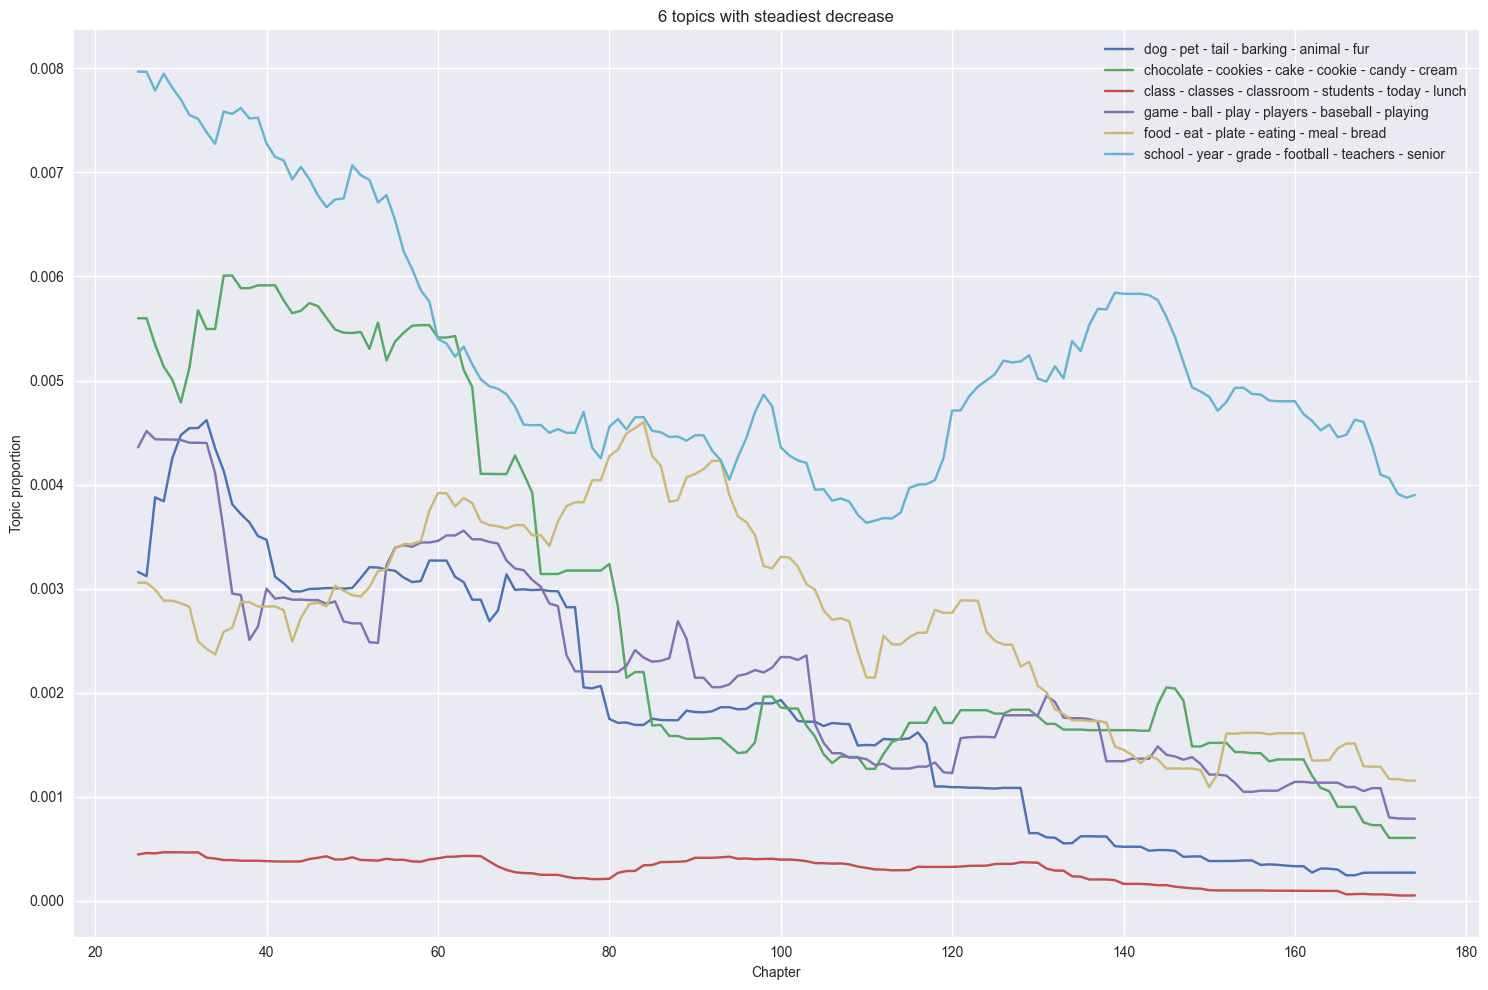

In [ ]:
import seaborn as sb
feature_names = vectorizer.get_feature_names_out()
fig = plt.figure(figsize=(15, 10))
sb.set_style("darkgrid")
for (feat, tau), col in zip(top, sb.color_palette("Set1")[:nb]):
    topic = nmf.components_[int(feat.replace('t', '')) - 1, :]
    words = [feature_names[i] for i in topic.argsort()[:-6-1:-1]]
    if 'rat' in words:
        continue
    label = ' - '.join(words)
    df[feat].rolling(window=50, center=True).mean().plot(label=label)
plt.xlabel('Chapter', fontsize=10)
plt.ylabel('Topic proportion', fontsize=10)
plt.title(f'{nb} topics with steadiest decrease')
plt.tight_layout()
plt.legend();

Interestingly, we see that they are indeed a number of "childish" topics that slowly fade out as the series progresses, relating to animals, school, birthdays and games. One topic, the "rat" topic, is remarkably present in the first novels, but this is a clear **artefact** of the fact that we have a character turning into a rat. Other topics, such as the one relating to the classroom setting, indeed are remarkably absent in the last chapters of the series.

If we make the same plot for the topics that have increase in relative weight, we see an opposed trend:

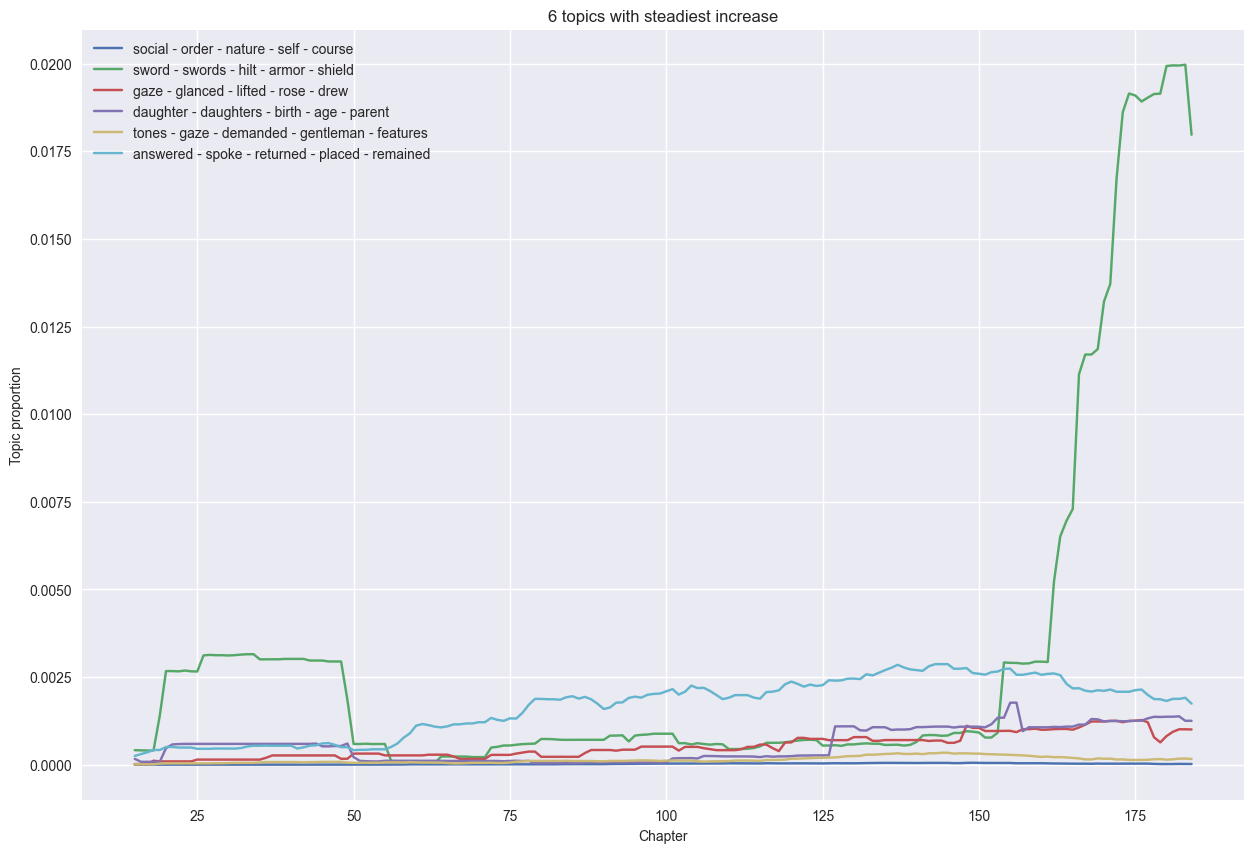

In [ ]:
fig = plt.figure(figsize=(15, 10))
sb.set_style("darkgrid")
for (feat, tau), col in zip(bottom, sb.color_palette("Set1")[:nb]):
    topic = nmf.components_[int(feat.replace('t', '')) - 1, :]
    words = [feature_names[i] for i in topic.argsort()[:-5-1:-1]]
    if 'spell' in words:
        continue
    label = ' - '.join(words)
    df[feat].rolling(window=30, center=True).mean().plot(label=label)
plt.xlabel('Chapter', fontsize=10)
plt.ylabel('Topic proportion', fontsize=10)
plt.title(f'{nb} topics with steadiest increase')
plt.legend();

Here, it becomes clear that the "spells" topic considerably outweighs the others, because of the specific thematic focus of the series. Interestingly, the other "booming" topics concern topic that could be characterized as more "adult" or "serious" topics, in comparison to the topics that faded out in the previous plot, relating to metaphysics, war and combat, and even even death. Therefore, our results would indeed support a linear reading of the series, where joyous and childisch themes have gradually made room for serious and darker topics.